In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.applications import DenseNet121
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization
from keras.applications import ResNet50
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
!pip install split-folders
import splitfolders

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# EDA

In [2]:
train_aug = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG'

In [3]:
print(f'The No of Sub-directories {len(os.listdir(train_aug))} ')
print()
images = 0
for dir in os.listdir(train_aug):
    subdir_path = os.path.join(train_aug, dir)
    
    if os.path.isdir(subdir_path):
        num_files = len(os.listdir(subdir_path))
        print(f'The No of Images inside the Sub-directory {dir}: {num_files}')
        images += num_files 
print()
print(f'Totol No of Images {images}')

The No of Sub-directories 9 

The No of Images inside the Sub-directory Neck_Blast: 1000
The No of Images inside the Sub-directory Leaf scald: 1332
The No of Images inside the Sub-directory Sheath Blight: 1629
The No of Images inside the Sub-directory Healthy Rice Leaf: 1085
The No of Images inside the Sub-directory Narrow Brown Leaf Spot: 954
The No of Images inside the Sub-directory Leaf Blast: 1748
The No of Images inside the Sub-directory Rice Hispa: 1299
The No of Images inside the Sub-directory Brown Spot: 1546
The No of Images inside the Sub-directory Bacterial Leaf Blight: 1197

Totol No of Images 11790


In [4]:
print(f'The No of Sub-directories {len(os.listdir(train_aug))} ')
print()
images_train_aug = 0
for dir in os.listdir(train_aug):
    subdir_path = os.path.join(train_aug, dir)
    
    if os.path.isdir(subdir_path):
        num_files = len(os.listdir(subdir_path))
        print(f'The No of Images percentage inside the Sub-directory {dir}: {(num_files / images) * 100 }')
        images_train_aug += num_files 
print()
print(f'Totol No of Images {images_train_aug}')

The No of Sub-directories 9 

The No of Images percentage inside the Sub-directory Neck_Blast: 8.481764206955047
The No of Images percentage inside the Sub-directory Leaf scald: 11.297709923664122
The No of Images percentage inside the Sub-directory Sheath Blight: 13.816793893129772
The No of Images percentage inside the Sub-directory Healthy Rice Leaf: 9.202714164546226
The No of Images percentage inside the Sub-directory Narrow Brown Leaf Spot: 8.091603053435115
The No of Images percentage inside the Sub-directory Leaf Blast: 14.826123833757421
The No of Images percentage inside the Sub-directory Rice Hispa: 11.017811704834605
The No of Images percentage inside the Sub-directory Brown Spot: 13.112807463952503
The No of Images percentage inside the Sub-directory Bacterial Leaf Blight: 10.15267175572519

Totol No of Images 11790


The No of Sub-directories 9 

The No of Images percentage inside the Sub-directory Neck_Blast: 8.481764206955047
The No of Images percentage inside the Sub-directory Leaf scald: 11.297709923664122
The No of Images percentage inside the Sub-directory Sheath Blight: 13.816793893129772
The No of Images percentage inside the Sub-directory Healthy Rice Leaf: 9.202714164546226
The No of Images percentage inside the Sub-directory Narrow Brown Leaf Spot: 8.091603053435115
The No of Images percentage inside the Sub-directory Leaf Blast: 14.826123833757421
The No of Images percentage inside the Sub-directory Rice Hispa: 11.017811704834605
The No of Images percentage inside the Sub-directory Brown Spot: 13.112807463952503
The No of Images percentage inside the Sub-directory Bacterial Leaf Blight: 10.15267175572519

Total No of Images 11790



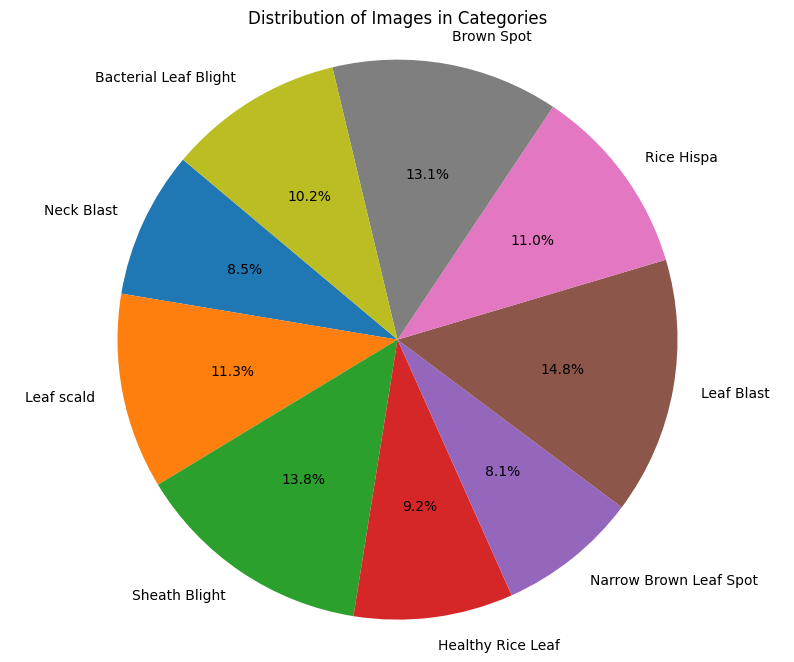

In [5]:
print(f'The No of Sub-directories {len(os.listdir(train_aug))} ')
print()

images = 0
categories = []
percentages = []

for dir in os.listdir(train_aug):
    subdir_path = os.path.join(train_aug, dir)
    
    if os.path.isdir(subdir_path):
        num_files = len(os.listdir(subdir_path))
        category_name = dir.replace('_', ' ')  # Optional: Replace underscores with spaces for better display
        categories.append(category_name)
        percentages.append((num_files / 11790) * 100)
        print(f'The No of Images percentage inside the Sub-directory {dir}: {(num_files / images_train_aug) * 100 }')
        images += num_files 

print()
print(f'Total No of Images {images}')

# Plotting the data
plt.figure(figsize=(10, 8))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Images in Categories')
print()
plt.show()

> **Images are evenly Distributed!!!**

# Model Creation

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
source_dir = train_aug
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

# Create destination directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each class subdirectory
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    
    # Get a list of all image files in the class directory
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Move images to respective directories
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)
    
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_name, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

# Print confirmation message
print("Image splitting completed.")


Image splitting completed.


In [7]:
print()
images_train = 0
for dir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, dir)
    
    if os.path.isdir(subdir_path):
        num_files = len(os.listdir(subdir_path))
        print(f'The No of Images inside the Sub-directory {dir}: {num_files}')
        images_train += num_files 
print()
print(f'Totol No of Images {images_train}')


The No of Images inside the Sub-directory Rice Hispa: 1039
The No of Images inside the Sub-directory Narrow Brown Leaf Spot: 763
The No of Images inside the Sub-directory Bacterial Leaf Blight: 957
The No of Images inside the Sub-directory Healthy Rice Leaf: 868
The No of Images inside the Sub-directory Neck_Blast: 800
The No of Images inside the Sub-directory Brown Spot: 1236
The No of Images inside the Sub-directory Leaf Blast: 1398
The No of Images inside the Sub-directory Leaf scald: 1065
The No of Images inside the Sub-directory Sheath Blight: 1303

Totol No of Images 9429


In [8]:
print()
images_test = 0
for dir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, dir)
    
    if os.path.isdir(subdir_path):
        num_files = len(os.listdir(subdir_path))
        print(f'The No of Images inside the Sub-directory {dir}: {num_files}')
        images_test += num_files 
print()
print(f'Totol No of Images {images_test}')


The No of Images inside the Sub-directory Rice Hispa: 260
The No of Images inside the Sub-directory Narrow Brown Leaf Spot: 191
The No of Images inside the Sub-directory Bacterial Leaf Blight: 240
The No of Images inside the Sub-directory Healthy Rice Leaf: 217
The No of Images inside the Sub-directory Neck_Blast: 200
The No of Images inside the Sub-directory Brown Spot: 310
The No of Images inside the Sub-directory Leaf Blast: 350
The No of Images inside the Sub-directory Leaf scald: 267
The No of Images inside the Sub-directory Sheath Blight: 326

Totol No of Images 2361


In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_ds = train_datagen.flow_from_directory(train_aug, 
    class_mode='categorical',
    batch_size = 32, 
    target_size = (256, 256))

test_ds = test_datagen.flow_from_directory(test_dir, 
    class_mode='categorical',
    batch_size = 32, 
    target_size = (256, 256))


Found 11790 images belonging to 9 classes.
Found 2361 images belonging to 9 classes.


In [12]:
from keras.applications import ResNet50

In [13]:
conv_l = ResNet50(weights = 'imagenet',
             include_top = False,
             input_shape = (256,256,3))

94765736/94765736 [==============================] - 1s 0us/step


In [14]:
conv_l.trainable = False

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization


In [16]:
model = Sequential()

In [17]:
model.add(conv_l)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(9,activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               33554688  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 9)                 2

In [19]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define batch size and total number of training and testing samples
batch_size = 32
total_train_samples = images_train_aug # 11790 images
total_test_samples = images_test # 2361 images

# Define the initial learning rate
initial_lr = 0.001

# Define the learning rate scheduler (Cyclical Learning Rate)
# clr = tfa.optimizers.CyclicalLearningRate(
#     initial_learning_rate=initial_lr,
#     maximal_learning_rate= 10 * initial_lr,
#     step_size= 2 * total_train_samples // batch_size,  # Total cycles = 2
#     scale_mode="cycle",
#     scale_fn=lambda x: 1 / (2.0 ** (x - 1))
# )

# Compile the model with the Adam optimizer and Cyclical Learning Rate
opt = Adam()
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with the learning rate scheduler and early stopping
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
#     steps_per_epoch=total_train_samples // batch_size,  
#     validation_steps=total_test_samples // batch_size,  
#     callbacks=[early_stopping]
)


Epoch 1/50
369/369 [==============================] - 336s 865ms/step - loss: 1.8247 - accuracy: 0.3544 - val_loss: 1.9501 - val_accuracy: 0.3011
Epoch 2/50
369/369 [==============================] - 322s 873ms/step - loss: 1.6439 - accuracy: 0.4193 - val_loss: 1.7309 - val_accuracy: 0.3892
Epoch 3/50
369/369 [==============================] - 317s 860ms/step - loss: 1.5746 - accuracy: 0.4407 - val_loss: 1.6377 - val_accuracy: 0.4485
Epoch 4/50
369/369 [==============================] - 319s 864ms/step - loss: 1.5525 - accuracy: 0.4531 - val_loss: 1.6564 - val_accuracy: 0.4532
Epoch 5/50
369/369 [==============================] - 302s 818ms/step - loss: 1.5165 - accuracy: 0.4624 - val_loss: 1.6192 - val_accuracy: 0.4413
Epoch 6/50
369/369 [==============================] - 303s 821ms/step - loss: 1.4875 - accuracy: 0.4735 - val_loss: 1.4541 - val_accuracy: 0.5095
Epoch 7/50
369/369 [==============================] - 312s 845ms/step - loss: 1.4803 - accuracy: 0.4805 - val_loss: 1.6039 -

Text(0.5, 1.0, 'Accuracy vs Validation accuracy')

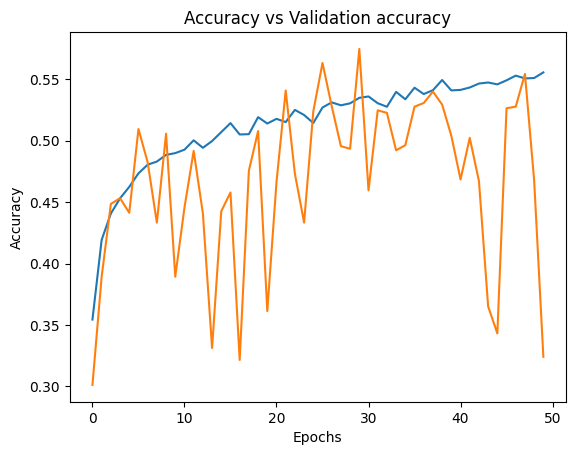

In [20]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Validation accuracy")

Text(0.5, 1.0, 'Loss vs Validation Loss')

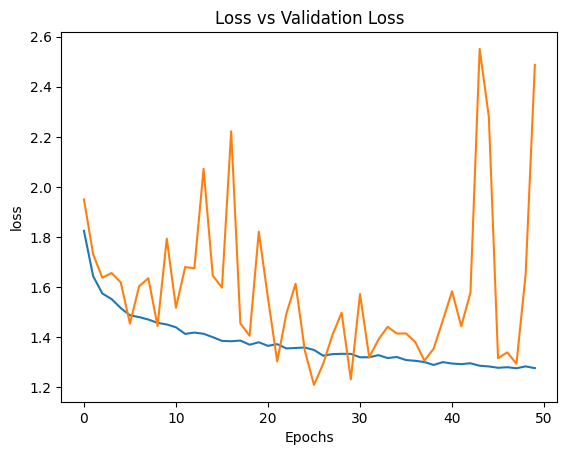

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Loss vs Validation Loss")

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)

74/74 [==============================] - 23s 291ms/step


<Figure size 800x600 with 0 Axes>

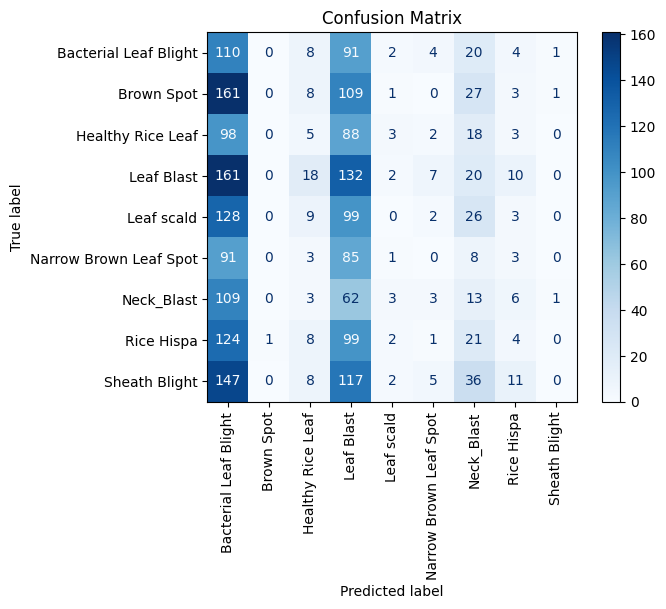

In [23]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(test_ds.class_indices.keys())  # Get class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.title('Confusion Matrix')
plt.show()

# Model Creation 2.0

In [24]:
from keras.applications import DenseNet121

In [25]:
conv_l = DenseNet121(weights = 'imagenet',
             include_top = False,
             input_shape = (256,256,3))

29084464/29084464 [==============================] - 0s 0us/step


In [26]:
conv_l.trainable = False

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization

In [28]:
model = Sequential()

In [29]:
model.add(conv_l)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(9,activation='softmax'))

In [30]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define batch size and total number of training and testing samples
batch_size = 32
total_train_samples = images_train_aug # 11790 images
total_test_samples = images_test # 2361 images8

# Define the initial learning rate
initial_lr = 0.001

# Define the learning rate scheduler (Cyclical Learning Rate)
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=initial_lr,
    maximal_learning_rate= 10 * initial_lr,
    step_size= 2 * total_train_samples // batch_size,  # Total cycles = 2
    scale_mode="cycle",
    scale_fn=lambda x: 1 / (2.0 ** (x - 1))
)

# Compile the model with the Adam optimizer and Cyclical Learning Rate
opt = Adam(learning_rate=clr)
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with the learning rate scheduler and early stopping
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    steps_per_epoch=total_train_samples // batch_size,  
    validation_steps=total_test_samples // batch_size,  
#     callbacks=[early_stopping]
)


Epoch 1/50
368/368 [==============================] - 317s 833ms/step - loss: 1.1059 - accuracy: 0.6343 - val_loss: 0.7111 - val_accuracy: 0.7671
Epoch 2/50
368/368 [==============================] - 300s 815ms/step - loss: 0.8047 - accuracy: 0.7168 - val_loss: 0.6425 - val_accuracy: 0.7851
Epoch 3/50
368/368 [==============================] - 297s 806ms/step - loss: 0.6688 - accuracy: 0.7619 - val_loss: 0.4014 - val_accuracy: 0.8664
Epoch 4/50
368/368 [==============================] - 303s 822ms/step - loss: 0.4917 - accuracy: 0.8295 - val_loss: 0.2477 - val_accuracy: 0.9127
Epoch 5/50
368/368 [==============================] - 294s 798ms/step - loss: 0.4198 - accuracy: 0.8539 - val_loss: 0.2380 - val_accuracy: 0.9199
Epoch 6/50
368/368 [==============================] - 299s 812ms/step - loss: 0.4622 - accuracy: 0.8375 - val_loss: 0.2642 - val_accuracy: 0.9097
Epoch 7/50
368/368 [==============================] - 285s 773ms/step - loss: 0.4382 - accuracy: 0.8472 - val_loss: 0.2036 -

Text(0.5, 1.0, 'Accuracy vs Validation accuracy')

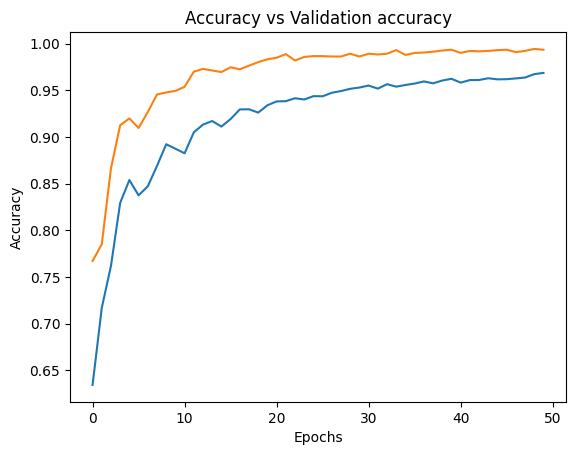

In [31]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Validation accuracy")

Text(0.5, 1.0, 'Loss vs Validation Loss')

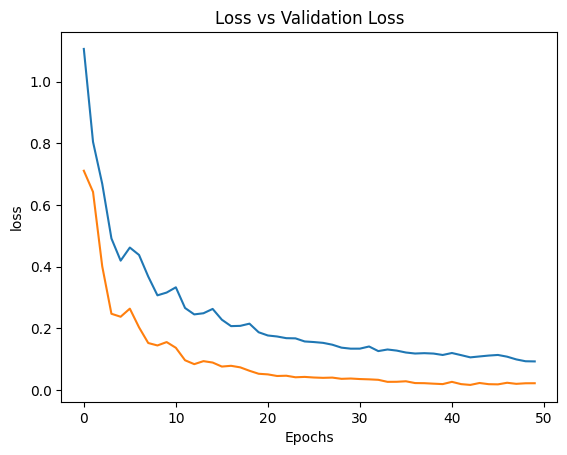

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Loss vs Validation Loss")

74/74 [==============================] - 25s 309ms/step


<Figure size 800x600 with 0 Axes>

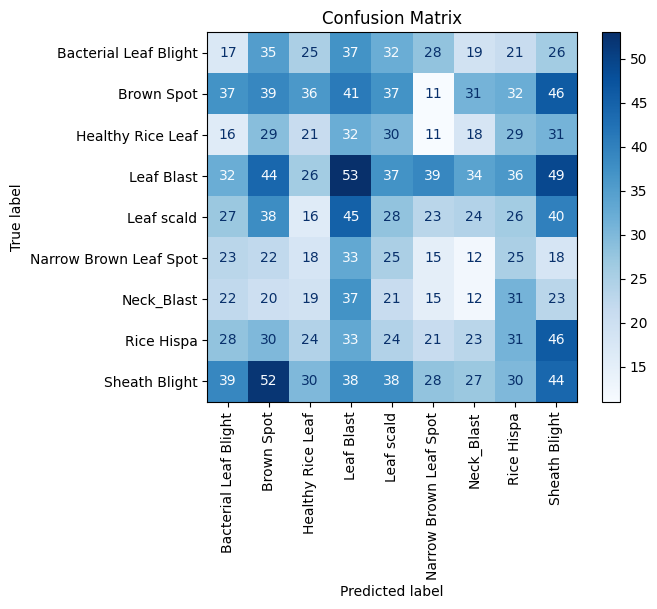

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(test_ds.class_indices.keys())  # Get class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.title('Confusion Matrix')
plt.show()

369/369 [==============================] - 262s 709ms/step


<Figure size 800x600 with 0 Axes>

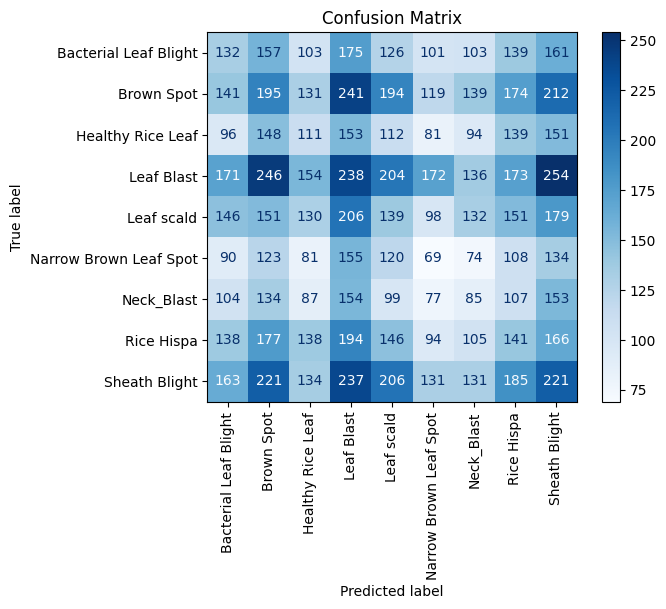

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels from the 'test_ds' directory iterator
true_labels = train_ds.labels

# Assuming 'model' is already trained
pred_probs = model.predict(train_ds)
pred_labels = np.argmax(pred_probs, axis=1)
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(test_ds.class_indices.keys())  # Get class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.title('Confusion Matrix')
plt.show()

In [35]:
model.save('my_dl_model.h5')

### Index of misclassifed images

In [36]:
misclassified_indices = np.where(true_labels != pred_labels)[0]


In [37]:
# Get the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(train_ds.class_indices.keys())
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# plt.figure(figsize=(8, 6))
# disp.plot(cmap=plt.cm.Blues)
# plt.xticks(rotation=90)
# plt.title('Confusion Matrix')
# plt.show()

# Find misclassified indices
misclassified_indices = np.where(true_labels != pred_labels)[0]

# Group misclassified indices by true class
misclassified_by_class = {}
for true_class in range(len(class_labels)):
    class_indices = np.where(true_labels[misclassified_indices] == true_class)[0]
    misclassified_by_class[class_labels[true_class]] = class_indices

# Assuming you have a function to display images (display_images(images))
# def display_images(images):
#     plt.figure(figsize=(10, 10))
#     for i, image_idx in enumerate(images):
#         plt.subplot(5, 5, i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(train_ds[misclassified_indices[image_idx]][0])  # Assuming train_ds is an ImageDataGenerator
#         plt.xlabel(f'Predicted: {class_labels[pred_labels[misclassified_indices[image_idx]]]}')
#     plt.show()

# # Display misclassified images class by class
# for true_class, misclassified_indices in misclassified_by_class.items():
#     print(f'Misclassified Images for Class {true_class}:')
#     display_images(misclassified_indices[:25])  # Display up to 25 misclassified images per class


In [38]:
misclassified_indices

array([    0,     1,     2, ..., 11785, 11786, 11787])

In [39]:
len(misclassified_by_class['Bacterial Leaf Blight'])

1065

##### If you look at the confusion matrix it won't add up to 99% i think model is overfitting. Let's try different approach

# Model Creation 3.0

In [40]:
input_folder = train_aug
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'
val_dir = '/kaggle/working/val'

In [41]:
splitfolders.ratio(input_folder, output=train_dir, seed=42, ratio=(0.7, 0.20, 0.10))


Copying files: 11790 files [00:28, 406.92 files/s]


In [42]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [43]:
train_ds = train_datagen.flow_from_directory(train_dir + '/train', 
    class_mode='categorical',
    batch_size = 32, 
    target_size = (256, 256),
                                            )

test_ds = test_datagen.flow_from_directory(train_dir + '/test', 
    class_mode='categorical',
    batch_size = 32, 
    target_size = (256, 256),shuffle=False)

val_ds = val_datagen.flow_from_directory(train_dir + '/val', 
    class_mode='categorical',
    batch_size = 32, 
    target_size = (256, 256),
    shuffle = False
                                        )

Found 8249 images belonging to 9 classes.
Found 1187 images belonging to 9 classes.
Found 2354 images belonging to 9 classes.


In [44]:
from keras.applications import DenseNet121

In [45]:
conv_l = DenseNet121(weights = 'imagenet',
             include_top = False,
             input_shape = (256,256,3))

In [46]:
conv_l.trainable = False

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization

In [48]:
model = Sequential()

In [49]:
model.add(conv_l)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(9,activation='softmax'))

In [50]:
images_train = 0
for dir in os.listdir(train_dir  + '/train'):
    subdir_path = os.path.join(train_dir + '/train', dir)
    
    if os.path.isdir(subdir_path):
        num_files = len(os.listdir(subdir_path))
        print(f'The No of Images inside the Sub-directory {dir}: {num_files}')
        images_train += num_files 
        
print()
print(images_train)

The No of Images inside the Sub-directory Rice Hispa: 909
The No of Images inside the Sub-directory Narrow Brown Leaf Spot: 667
The No of Images inside the Sub-directory Bacterial Leaf Blight: 837
The No of Images inside the Sub-directory Healthy Rice Leaf: 759
The No of Images inside the Sub-directory Neck_Blast: 700
The No of Images inside the Sub-directory Brown Spot: 1082
The No of Images inside the Sub-directory Leaf Blast: 1223
The No of Images inside the Sub-directory Leaf scald: 932
The No of Images inside the Sub-directory Sheath Blight: 1140

8249


In [51]:
images_test = 0
for dir in os.listdir(train_dir  + '/test'):
    subdir_path = os.path.join(train_dir  + '/test', dir)
    
    if os.path.isdir(subdir_path):
        num_files = len(os.listdir(subdir_path))
        print(f'The No of Images inside the Sub-directory {dir}: {num_files}')
        images_test += num_files 
print()
print(images_test)

The No of Images inside the Sub-directory Rice Hispa: 131
The No of Images inside the Sub-directory Narrow Brown Leaf Spot: 97
The No of Images inside the Sub-directory Bacterial Leaf Blight: 121
The No of Images inside the Sub-directory Healthy Rice Leaf: 109
The No of Images inside the Sub-directory Neck_Blast: 100
The No of Images inside the Sub-directory Brown Spot: 155
The No of Images inside the Sub-directory Leaf Blast: 176
The No of Images inside the Sub-directory Leaf scald: 134
The No of Images inside the Sub-directory Sheath Blight: 164

1187


In [52]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define batch size and total number of training and testing samples
batch_size = 32
# total_train_samples = images_train # 11790 images
# total_test_samples = images_test # 2361 images

# Define the initial learning rate
initial_lr = 0.001

# Define the learning rate scheduler (Cyclical Learning Rate)
# clr = tfa.optimizers.CyclicalLearningRate(
#     initial_learning_rate=initial_lr,
#     maximal_learning_rate= 10 * initial_lr,
#     step_size= 2 * total_train_samples // batch_size,  # Total cycles = 2
#     scale_mode="cycle",
#     scale_fn=lambda x: 1 / (2.0 ** (x - 1))
# )

# Compile the model with the Adam optimizer and Cyclical Learning Rate
opt = Adam()
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with the learning rate scheduler and early stopping
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
#     steps_per_epoch=total_train_samples // batch_size,  
#     validation_steps=total_test_samples // batch_size,  
#     callbacks=[early_stopping]
)

Epoch 1/50
258/258 [==============================] - 196s 730ms/step - loss: 1.1846 - accuracy: 0.6249 - val_loss: 0.6352 - val_accuracy: 0.7877
Epoch 2/50
258/258 [==============================] - 183s 708ms/step - loss: 0.7481 - accuracy: 0.7391 - val_loss: 0.4914 - val_accuracy: 0.8265
Epoch 3/50
258/258 [==============================] - 187s 726ms/step - loss: 0.6433 - accuracy: 0.7757 - val_loss: 0.4341 - val_accuracy: 0.8551
Epoch 4/50
258/258 [==============================] - 183s 711ms/step - loss: 0.5701 - accuracy: 0.8023 - val_loss: 0.3958 - val_accuracy: 0.8677
Epoch 5/50
258/258 [==============================] - 185s 717ms/step - loss: 0.5223 - accuracy: 0.8168 - val_loss: 0.3488 - val_accuracy: 0.8821
Epoch 6/50
258/258 [==============================] - 190s 737ms/step - loss: 0.4848 - accuracy: 0.8303 - val_loss: 0.3102 - val_accuracy: 0.8955
Epoch 7/50
258/258 [==============================] - 186s 722ms/step - loss: 0.4550 - accuracy: 0.8383 - val_loss: 0.2796 -

38/38 [==============================] - 13s 296ms/step


<Figure size 800x600 with 0 Axes>

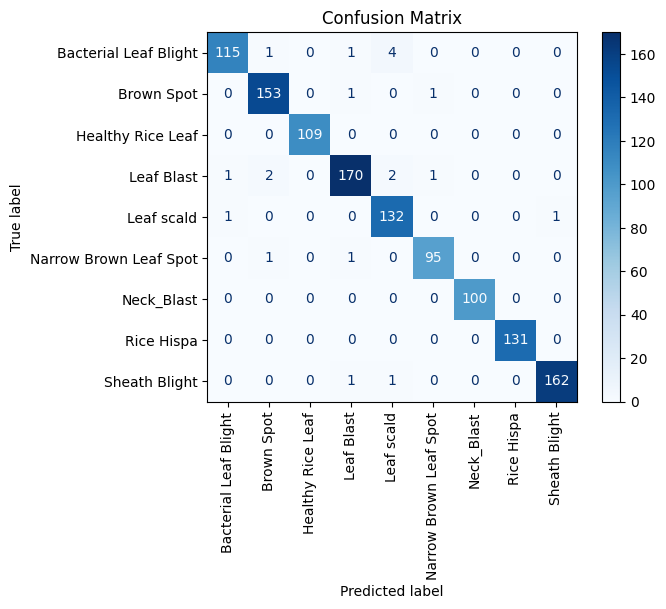

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(test_ds.class_indices.keys())  # Get class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.title('Confusion Matrix')
plt.show()

In [54]:
# true_labels1 = val_ds.labels

# # Assuming 'model' is already trained
# pred_probs1 = model.predict(val_ds)
# pred_labels1 = np.argmax(pred_probs1, axis=1)
# conf_matrix1 = confusion_matrix(true_labels1, pred_labels1)

# # Display the confusion matrix
# class_labels1 = list(val_ds.class_indices.keys())  # Get class labels from the generator
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix1, display_labels=class_labels1)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# disp.plot(cmap=plt.cm.Blues)

# # Rotate x-axis labels by 90 degrees
# plt.xticks(rotation=90)

# plt.title('Confusion Matrix')
# plt.show()

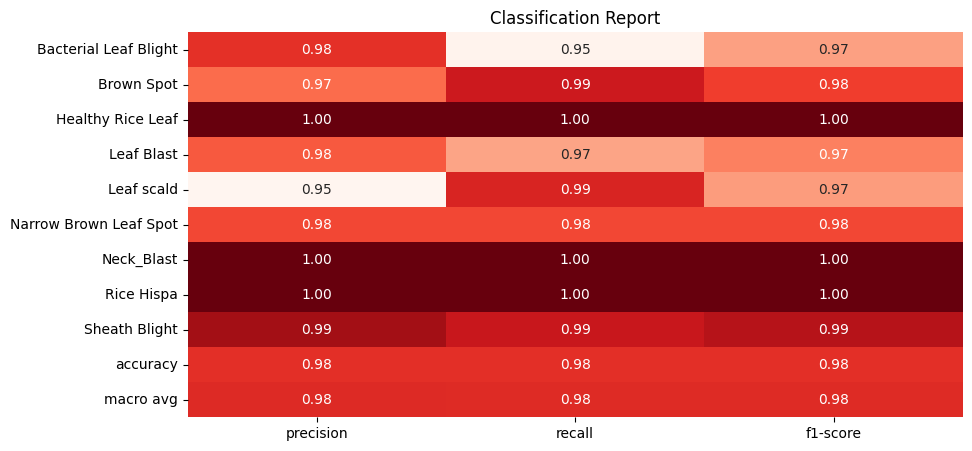

In [55]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels1 and pred_labels1 from your CNN model

# Generate a classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels, output_dict=True)

# Convert the report to a DataFrame for better visualization
import pandas as pd
report_df = pd.DataFrame(report).transpose()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap=plt.cm.Reds,fmt=".2f", cbar=False)
plt.title('Classification Report')
plt.show()


In [56]:
model.save('my_model.h5')

# Testing Deep Learning Model With Web Data

In [57]:
from skimage import io
import tensorflow as tf

In [58]:
values = val_ds.class_indices.keys()
keys = [0,1,2,4,5,6,7,8]


In [59]:
Output_dict = dict(zip(keys,values))

In [60]:
Output_dict

{0: 'Bacterial Leaf Blight',
 1: 'Brown Spot',
 2: 'Healthy Rice Leaf',
 4: 'Leaf Blast',
 5: 'Leaf scald',
 6: 'Narrow Brown Leaf Spot',
 7: 'Neck_Blast',
 8: 'Rice Hispa'}

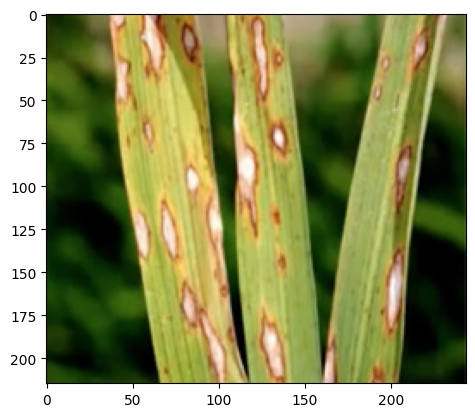

In [61]:
plt.imshow(io.imread('https://agritech.tnau.ac.in/crop_protection/images/rice_diseases/blast_1.jpg'))

In [7]:
from skimage import io, transform

image_array = io.imread('https://agritech.tnau.ac.in/crop_protection/images/rice_diseases/blast_1.jpg')

# Resize the image to match the expected input shape of your model
resized_image = transform.resize(image_array, (256, 256))

preprocessed_image = resized_image / 255.0

ModuleNotFoundError: No module named 'skimage'

In [ ]:
# prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))


In [4]:
predicted_class_index = np.argmax(prediction)


NameError: name 'np' is not defined

In [ ]:
Output_dict[predicted_class_index]

In [6]:
def predict_web_image(url):
    try:
        image_array = io.imread(url)

        # Resize the image to match the expected input shape of your model
        resized_image = transform.resize(image_array, (256, 256))

        preprocessed_image = resized_image / 255.0

        prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))

        predicted_class_index = np.argmax(prediction)

        print(f"The predicted image has {Output_dict[predicted_class_index]} disease")

    except Exception as e:
        print(f"An error occurred: {e}")

# Assuming 'model' and 'Output_dict' are defined elsewhere in your code

        
    
def plot_web_image(url):
    plt.imshow(io.imread(url))
    
    
    

In [ ]:
predict_web_image('')

In [ ]:
plot_web_image('https://1.bp.blogspot.com/-WXV-JPCBc-Y/X0EflszH76I/AAAAAAAABFo/bX1FtzzsgQcMHbyT6g4_VvdOa7mO8IssACLcBGAsYHQ/s640/RiceBlast1.webp')

**There are slight change in Model 3.0,**

>  test_ds = test_datagen.flow_from_directory(train_dir + '/test', 
>      class_mode='categorical',
>      batch_size = 32, 
>      target_size = (256, 256), 
>      shuffle=False)
> 

**by setting shuffle = False leads to a perfect confusion matrix.
Key takes from "Model 3.0" are model performing very well but "Bacterial Leaf Blight" disease getting misclassfied. Aiming to use lesser dense model with current accuracy and Implementing RNN to classify the images.** 

- Saving Model for deployment

In [ ]:
model.save('my_final_model.h5')